In [34]:
#import libraries
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam

rand_state = 123
import random
random.seed(rand_state)

In [35]:
# Load the MNIST Fashion dataset
filename = 'fashion-mnist.csv'
df = pd.read_csv(filename)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# Normalize pixel values between [0, 1]
X = X / 255

# Only use 50% of data
rand = random.sample(range(10000), 5000)
X = X[rand]
y = y[rand]

# One-hot encoding
y = to_categorical(y)

# Split the dataset into training and test data sets
X_left, X_gen, y_left, y_gen = train_test_split(X, y, test_size=0.2, random_state=rand_state)
X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.25, random_state=rand_state)

In [36]:
# Define the CNN model
def create_model(learning_rate, dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [37]:
# Define the search space for the hyperparameters
lr_min, lr_max = 1e-4, 1e-2
dr_min, dr_max = 0.0, 0.5
search_space = [Real(lr_min, lr_max, name='learning_rate'),
                Real(dr_min, dr_max, name='dropout_rate')]

In [38]:
# Define the objective function to minimize (i.e., 1 - accuracy)
acc_list = []
n_epoch = 5

@use_named_args(search_space)
def objective_f(**params):
    # Create the model
    model = create_model(**params)

    # Fit the model to the training data
    model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=n_epoch, verbose=0)

    # Predict the labels for the test data
    y_pred = model.predict(X_test.reshape(-1, 28, 28, 1))

    # Convert the predicted labels to integers
    y_pred = np.argmax(y_pred, axis=1)

    # Compute the accuracy of the model
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

    acc_list.append(accuracy)

    # Return 1 - accuracy (to minimize)
    return 1.0 - accuracy

# Define the objective function to minimize (i.e., 1 - accuracy) for random sampling with generalization set
@use_named_args(search_space)
def objective_r(**params):
    # Create the model
    model = create_model(**params)

    # Fit the model to the training data
    model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=n_epoch, verbose=0)

    # Predict the labels for the test data
    y_pred = model.predict(X_gen.reshape(-1, 28, 28, 1))

    # Convert the predicted labels to integers
    y_pred = np.argmax(y_pred, axis=1)

    # Compute the accuracy of the model
    accuracy = accuracy_score(np.argmax(y_gen, axis=1), y_pred)

    acc_list.append(accuracy)

    # Return 1 - accuracy (to minimize)
    return 1.0 - accuracy

In [39]:
# Random sampling of hyperparameters
n_rand = 30
rand_lr = [random.uniform(lr_min, lr_max) for _ in range(n_rand)]
rand_dr = [random.uniform(dr_min, dr_max) for _ in range(n_rand)]

# Train model with each set of random hyperparameters
for rand in zip(rand_lr, rand_dr):
    objective_f(rand)

# Print accuracy fro these new models
acc_list_r = acc_list
acc_list = []
print(acc_list_r)

32/32 [==============================] - 0s 7ms/step
[0.824, 0.799, 0.796, 0.814, 0.82, 0.783, 0.789, 0.798, 0.803, 0.8, 0.812, 0.817, 0.82, 0.804, 0.811, 0.744, 0.783, 0.775, 0.803, 0.806, 0.777, 0.827, 0.809, 0.793, 0.838, 0.809, 0.766, 0.814, 0.813, 0.801]


In [40]:
# Best random sample
best_idx = np.argmax(acc_list_r)
best_acc = acc_list_r[best_idx]
best_lr = rand_lr[best_idx]
best_dr = rand_dr[best_idx]
print(f" Best acc: {best_acc}, best LR: {best_lr}, best dr: {best_dr}")

 Best acc: 0.838, best LR: 0.0049272845613907304, best dr: 0.04776734032469421


In [41]:
# Define the first 10 points that BO should evaluate - gotten from the random sample
x_0 = [rand_lr[0], rand_dr[0]]
y_0 = acc_list_r[0]

# Perform Bayesian optimization
n_bo = 29
result = gp_minimize(objective_f, search_space, n_calls=n_bo, random_state=rand_state, acq_func="gp_hedge", x0=x_0, y0=y_0)

# Print the best set of hyperparameters and the corresponding accuracy
print(f'Best hyperparameters [lr, dr]: {result.x}')
print(f'Best accuracy: {1.0 - result.fun}')

# Print prior test accuracies
acc_list_bo = [y_0] + acc_list
acc_list = []
print(acc_list_bo)

32/32 [==============================] - 0s 3ms/step
Best hyperparameters [lr, dr]: [0.0022951257350985995, 0.10977760774887575]
Best accuracy: 0.842
[0.824, 0.787, 0.791, 0.763, 0.812, 0.797, 0.834, 0.806, 0.809, 0.794, 0.812, 0.812, 0.813, 0.764, 0.778, 0.774, 0.804, 0.788, 0.842, 0.825, 0.792, 0.785, 0.809, 0.719, 0.789, 0.799, 0.805, 0.82, 0.803, 0.812]


In [42]:
# Check model used
print(result.models[0])
# See kernel is Matern 5/2 with a white noise kernel added to it
# Default xi = 0.01 for EI and PI and kappa = 1.96 for LCB

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=843828734)


In [43]:
# Define optimal model with found hyperparameters
opt_model = create_model(*result.x)

# Fit the model to the training data
opt_model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=n_epoch, verbose=0)

# Predict the labels for the test data
y_pred_opt = opt_model.predict(X_gen.reshape(-1, 28, 28, 1))

# Convert the predicted labels to integers
y_pred_opt = np.argmax(y_pred_opt, axis=1)

# Compute the accuracy of the model
accuracy_opt = accuracy_score(np.argmax(y_gen, axis=1), y_pred_opt)

# Print accuracy for optimal model
print(accuracy_opt)

32/32 [==============================] - 1s 7ms/step
0.826


In [44]:
# Train model with each set of random hyperparameters
for rand in zip(rand_lr, rand_dr):
    objective_r(rand)

# Print accuracy fro these new models
acc_list_rg = acc_list
acc_list = []
print(acc_list_rg)

32/32 [==============================] - 0s 4ms/step
[0.833, 0.815, 0.816, 0.808, 0.855, 0.827, 0.831, 0.828, 0.836, 0.827, 0.823, 0.799, 0.838, 0.824, 0.826, 0.765, 0.785, 0.794, 0.808, 0.813, 0.836, 0.82, 0.813, 0.841, 0.85, 0.822, 0.791, 0.847, 0.818, 0.809]


In [45]:
# Statisical test and confidence interval
alpha = 0.05

# Create 95% confidence interval for random sampling
ci_rg = st.t.interval(confidence=1-alpha, df=len(acc_list_rg)-1, loc=np.mean(acc_list_rg), scale=st.sem(acc_list_rg))
print("Confidence interval for accuracy from random sampling on generalization set: ", ci_rg)

# Show optimal accuracy
print(f"Optimal accuracy from BO: {accuracy_opt}, is it in cf_rg?")

Confidence interval for accuracy from random sampling on generalization set:  (0.8125273169160165, 0.8273393497506505)
Optimal accuracy from BO: 0.826, is it in cf_rg?


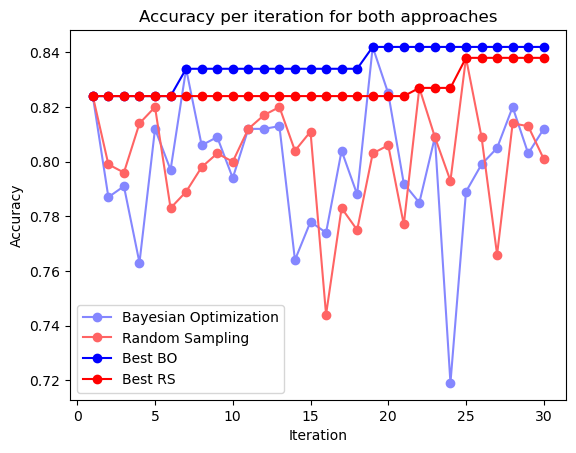

In [46]:
# Plot of accuracies
x = np.linspace(1, 30, 30).astype(int)
best_bo = [acc_list_bo[0]]
best_r = [acc_list_r[0]]

# Check if a new accuracy is better
for bo, r in zip(acc_list_bo[1:], acc_list_r[1:]):
    if bo > best_bo[-1]:
        best_bo.append(bo)
    else:
        best_bo.append(best_bo[-1])
    
    if r > best_r[-1]:
        best_r.append(r)
    else:
        best_r.append(best_r[-1])

# Define plot parts
plt.plot(x, acc_list_bo, c='#8587FF', ls='-', marker='o', label = 'Bayesian Optimization')
plt.plot(x, acc_list_r, c='#FF6464', ls='-', marker='o', label = 'Random Sampling')
plt.plot(x, best_bo, 'ob-', label = 'Best BO')
plt.plot(x, best_r, 'or-', label = 'Best RS')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per iteration for both approaches')
plt.legend()
plt.show()